In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# ===========================================================
# 1. 解析单个日志文件（只取最后一个值）
# ===========================================================

re_train = re.compile(r"train loss:\s*([\d\.Ee+\-]+)")
re_valid = re.compile(r"valid loss:\s*([\d\.Ee+\-]+)")
re_dyn = re.compile(r"dyn_dyn_loss\s*:\s*([\d\.Ee+\-]+)")


def parse_log_last(path):
    train_vals, valid_vals, dyn_vals = [], [], []

    with open(path, "r") as f:
        for line in f:
            m = re_train.search(line)
            if m:
                train_vals.append(float(m.group(1)))

            m = re_valid.search(line)
            if m:
                valid_vals.append(float(m.group(1)))

            m = re_dyn.search(line)
            if m:
                dyn_vals.append(float(m.group(1)))
    print(dyn_vals)
    return {
        "train_loss": train_vals[-1] if train_vals else None,
        "valid_loss": valid_vals[-1] if valid_vals else None,
        "dyn_loss":   dyn_vals[-1] if dyn_vals else None,
    }



# ===========================================================
# 2. 从文件名解析参数
# ===========================================================

def parse_filename(fname):
    # 新格式: N{N}_tp{tp}_ratio{ratio}_pos{pos}.log
    m = re.search(r"N(\d+)_tp(\d+)_ratio([0-9.]+)_pos([0-9.]+)\.log", fname)
    if not m:
        return None
    return {
        "N":     int(m.group(1)),
        "tp":    int(m.group(2)),
        "ratio": float(m.group(3)),   # ratio_dyn
        "pos":   float(m.group(4)),   # pos_ratio
    }



# ===========================================================
# 3. 读取全部日志
# ===========================================================

def load_all_logs(log_dir):
    results = {}  # results[N][tp][t][ratio]

    for fname in os.listdir(log_dir):
        if not fname.endswith(".log"):
            continue

        params = parse_filename(fname)
        if params is None:
            continue

        path = os.path.join(log_dir, fname)
        stat = parse_log_last(path)

        N = params["N"]
        tp = params["tp"]
        pos = params["pos"]
        ratio = params["ratio"]

        results.setdefault(N, {})
        results[N].setdefault(tp, {})
        results[N][tp].setdefault(pos, {})
        results[N][tp][pos].setdefault(ratio, {})
        results[N][tp][pos][ratio] = stat

    return results


# ===========================================================
# 4. 绘图（matplotlib）
# ===========================================================
def plot_loss_vs_ratio(results, N, pos_list=[0.125, 0.25, 0.5, 0.75, 0.875]):
    """
    绘图逻辑变化：
    - 不同 pos_ratio 使用不同颜色主色（例如 5 个 pos 就用 tab10 前 5 个颜色）
    - 同一 pos_ratio 下：tp 小→浅，tp 大→深
    - 其它逻辑完全不变
    """

    if N not in results:
        raise ValueError(f"No data for N={N}")

    # tp 列表
    tp_list = sorted(results[N].keys())

    # 两个子图
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax_train, ax_valid = ax

    base_cmap = plt.get_cmap("tab10")

    # 对每个 pos_ratio 单独画一组颜色
    for idx_pos, pos in enumerate(pos_list):

        if pos not in next(iter(results[N].values())):
            print(f"[Warning] pos_ratio={pos} not found; skip.")
            continue

        base_color = np.array(base_cmap(idx_pos % 10))
        num_tp = len(tp_list)

        for i, tp in enumerate(tp_list):
            # 颜色深浅控制（同一 pos 内 tp 小→浅，tp 大→深）
            depth = 0.5 + 0.5 * (i / max(1, num_tp - 1))
            color = base_color.copy()
            color[:3] *= depth
            color = np.clip(color, 0, 1)

            if pos not in results[N][tp]:
                continue

            # 取 (ratio -> {train_loss, valid_loss}) 数据
            items = sorted(results[N][tp][pos].items(), key=lambda x: x[0])

            ratios     = [r for r, _ in items]
            train_vals = [d["train_loss"] for _, d in items]
            valid_vals = [d["valid_loss"] for _, d in items]

            label = f"pos={pos}, tp={tp}"

            ax_train.plot(
                ratios, train_vals,
                marker="o", color=color, linewidth=2, label=label
            )
            ax_valid.plot(
                ratios, valid_vals,
                marker="o", color=color, linewidth=2, label=label
            )

    ax_train.set_title(f"N={N} — Train Loss vs Ratio")
    ax_valid.set_title(f"N={N} — Valid Loss vs Ratio")

    ax_train.set_xlabel("ratio")
    ax_valid.set_xlabel("ratio")
    ax_train.set_ylabel("train loss")
    ax_valid.set_ylabel("valid loss")

    ax_train.grid(True, linestyle="--", alpha=0.4)
    ax_train.set_yscale("log")
    ax_valid.grid(True, linestyle="--", alpha=0.4)
    # ax_valid.set_yscale("log")

    # ax_train.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
    ax_valid.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

    plt.tight_layout()
    plt.show()

results = load_all_logs(".")

[0.09255, 0.09101, 0.08746, 0.08344, 0.0792, 0.07524, 0.07267, 0.07062, 0.0698, 0.06936, 0.06996, 0.07089, 0.07223, 0.07324, 0.07399, 0.07399, 0.07413, 0.07367, 0.0728, 0.0725, 0.07137, 0.07072, 0.07001, 0.06902, 0.06806, 0.06724, 0.06702, 0.06616, 0.0653, 0.06453, 0.06399, 0.06356, 0.06252, 0.06239, 0.06178, 0.06145, 0.0609, 0.06066, 0.05985, 0.05958, 0.05917, 0.05872, 0.0587, 0.05834, 0.05818, 0.05784, 0.05767, 0.05736, 0.05729, 0.05726, 0.05709, 0.05701, 0.05704, 0.05667, 0.05664, 0.05632, 0.05622, 0.05651, 0.05595, 0.05574, 0.05592, 0.05534, 0.05527, 0.05532, 0.05519, 0.05519, 0.05525, 0.05501, 0.05466, 0.05475, 0.05474, 0.05451, 0.0545, 0.05434, 0.05467, 0.05466, 0.05427, 0.05457, 0.05433, 0.05446, 0.0541, 0.05444, 0.05413, 0.05392, 0.05411, 0.05412, 0.05376, 0.05395, 0.05397, 0.05393, 0.0541, 0.05367, 0.05374, 0.05366, 0.05377, 0.05345, 0.05386, 0.05356, 0.0534, 0.05336]
[0.09628, 0.09376, 0.08844, 0.08333, 0.07872, 0.0756, 0.07423, 0.07491, 0.077, 0.08055, 0.08528, 0.09079, 0.09

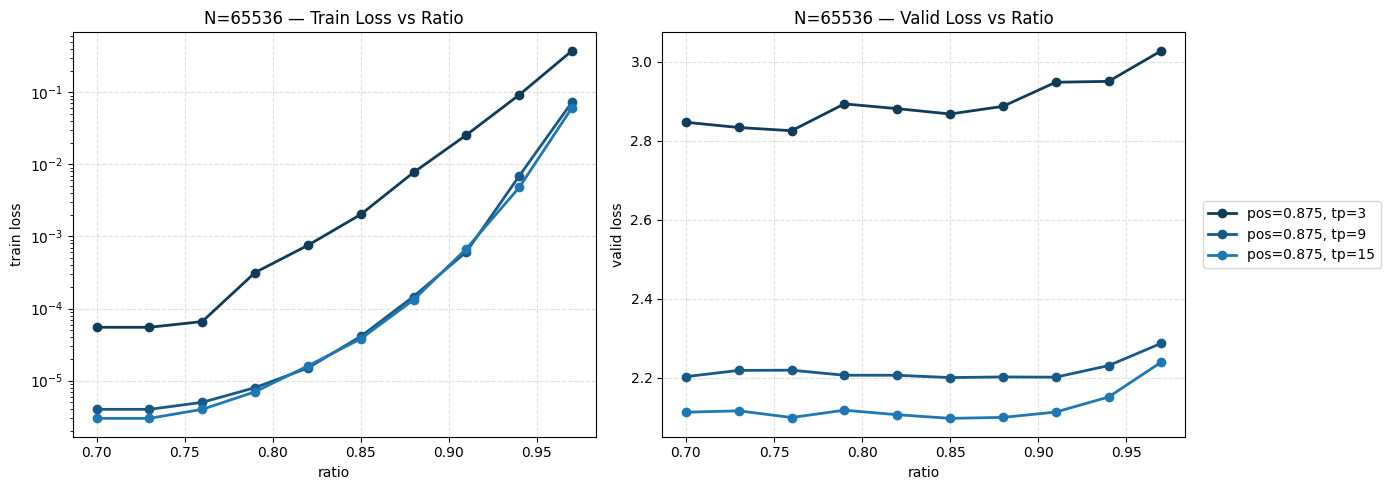

In [3]:
plot_loss_vs_ratio(results, N=65536, pos_list=[0.875])

In [4]:
def plot_loss_vs_ratio_3(results, N, tp_list=None):
    """
    三联图版本：
    0. ratio → (train_loss - dyn_loss)
    1. ratio → train_loss
    2. ratio → valid_loss

    颜色策略：
    - 不同 tp 一个主色（tab10）
    - 同一 tp 内 pos 小→浅，pos 大→深
    """

    import numpy as np
    import matplotlib.pyplot as plt

    if N not in results:
        raise ValueError(f"No data for N={N}")

    # 自动获取 tp_list
    if tp_list is None:
        tp_list = sorted(results[N].keys())

    # 自动抽取 pos_list（所有 tp 的并集）
    pos_set = set()
    for tp in tp_list:
        pos_set |= set(results[N][tp].keys())
    pos_list = sorted(pos_set)

    # ===========================
    # 3 张横向子图
    # ===========================
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    ax_diff, ax_train, ax_valid = axes

    base_cmap = plt.get_cmap("tab10")

    # ===========================
    # 绘图主循环
    # ===========================
    for idx_tp, tp in enumerate(tp_list):

        base_color = np.array(base_cmap(idx_tp % 10))  # 主色 = tp 的颜色
        num_pos = len(pos_list)

        for i, pos in enumerate(pos_list):

            if pos not in results[N][tp]:
                continue

            # 明暗控制
            depth = 0.5 + 0.5 * (i / max(1, num_pos - 1))
            color = base_color.copy()
            color[:3] *= depth
            color = np.clip(color, 0, 1)

            # 获取 ratio 数据
            items = sorted(results[N][tp][pos].items(), key=lambda x: x[0])

            ratios = []
            diff_vals = []
            train_vals = []
            valid_vals = []

            for r, d in items:
                ratios.append(r)
                train_vals.append(d["train_loss"])
                valid_vals.append(d["valid_loss"])
                diff_vals.append(d["dyn_loss"])

            label = f"tp={tp}, pos={pos}"

            # 0. diff 图
            ax_diff.plot(
                ratios, diff_vals,
                marker="o", linewidth=2, color=color
            )

            # 1. train 图
            ax_train.plot(
                ratios, train_vals,
                marker="o", linewidth=2, color=color
            )

            # 2. valid 图
            ax_valid.plot(
                ratios, valid_vals,
                marker="o", linewidth=2, color=color, label=label
            )

    # ===========================
    # 统一格式
    # ===========================
    ax_diff.set_title(f"N={N} — dyn_loss vs Ratio")
    ax_train.set_title(f"N={N} — Train Loss vs Ratio")
    ax_valid.set_title(f"N={N} — Valid Loss vs Ratio")

    ax_diff.set_xlabel("ratio")
    ax_train.set_xlabel("ratio")
    ax_valid.set_xlabel("ratio")

    ax_diff.set_ylabel("dyn_loss")
    ax_train.set_ylabel("train loss")
    ax_valid.set_ylabel("valid loss")

    # y 轴 log（中间图保持 log）
    ax_train.set_yscale("log")

    for ax in axes:
        ax.grid(True, linestyle="--", alpha=0.4)

    # legend 放在最右侧并超出图形
    ax_valid.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        title="tp / pos"
    )

    plt.tight_layout()
    plt.show()


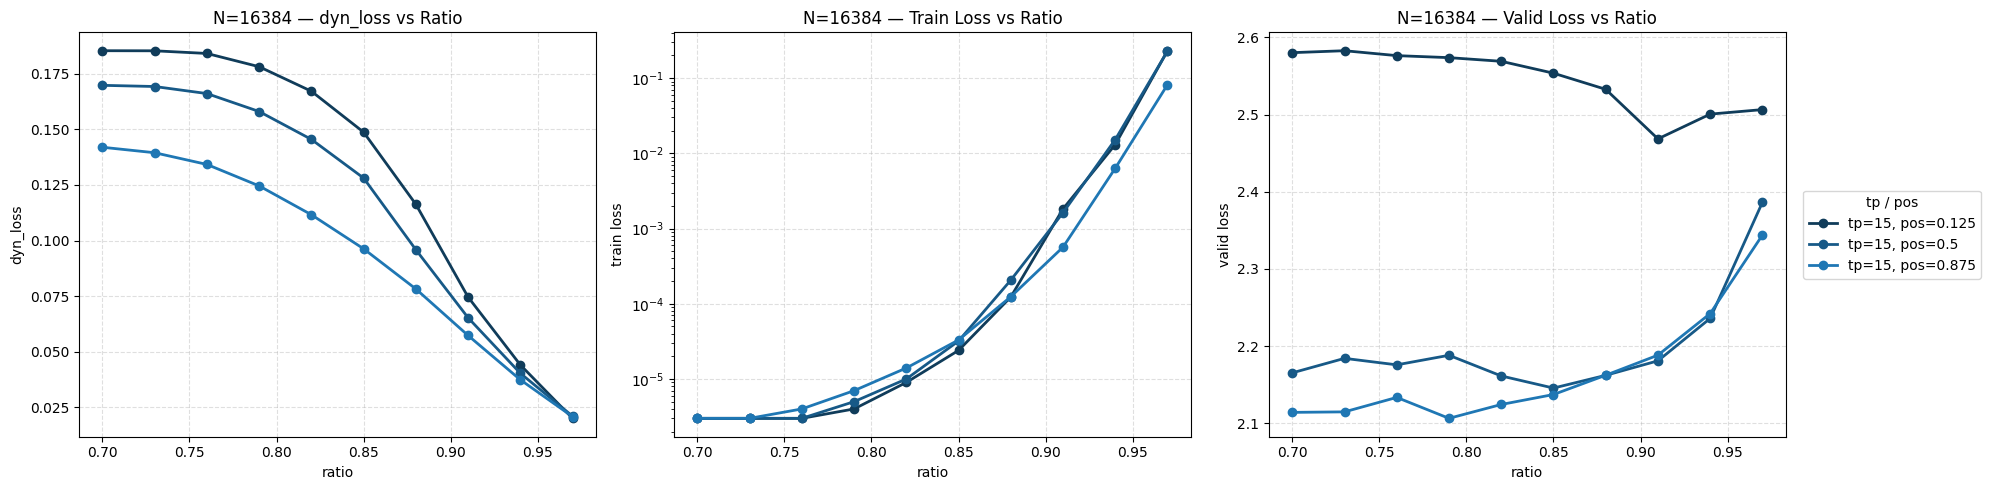

In [5]:
plot_loss_vs_ratio_3(results, N=16384, tp_list=[15])

In [6]:
def plot_loss_vs_ratio_swap_pos_N(results, tp_list=[3, 9, 15], pos_list=[0.125, 0.5, 0.875], N_list=[1024, 2048, 4096]):
    """
    pos 与 N 完全互换后的逻辑：

    颜色主色：不同 pos_ratio
    颜色明暗：同一 pos_ratio 内，N 小→浅，N 大→深

    固定 tp，一次画所有 tp（每个 tp 一组三联图）。

    三联图分别为：
    0. ratio → (train_loss - dyn_loss)
    1. ratio → train_loss      (log)
    2. ratio → valid_loss
    """

    import numpy as np
    import matplotlib.pyplot as plt

    # 自动推断所有 N_list
    if N_list is None:
        N_list = sorted(results.keys())

    # 自动推断所有 tp_list
    if tp_list is None:
        tp_set = set()
        for N in N_list:
            tp_set |= set(results[N].keys())
        tp_list = sorted(tp_set)

    # 自动推断所有 pos_list
    if pos_list is None:
        pos_set = set()
        for N in N_list:
            for tp in results[N]:
                pos_set |= set(results[N][tp].keys())
        pos_list = sorted(pos_set)

    base_cmap = plt.get_cmap("tab10")   # 主色 = pos
    num_pos = len(pos_list)
    num_N = len(N_list)

    # ====================================================
    #   主循环：对每个 tp 单独绘制一组三联图
    # ====================================================
    for tp in tp_list:

        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        ax_diff, ax_train, ax_valid = axes

        for idx_pos, pos in enumerate(pos_list):

            base_color = np.array(base_cmap(idx_pos % 10))  # 主色 = pos 的颜色

            for idx_N, N in enumerate(N_list):

                if N not in results or tp not in results[N] or pos not in results[N][tp]:
                    continue

                # 明暗：N 小 → 浅；N 大 → 深
                depth = 0.5 + 0.5 * (idx_N / max(1, num_N - 1))
                color = base_color.copy()
                color[:3] *= depth
                color = np.clip(color, 0, 1)

                items = sorted(results[N][tp][pos].items(), key=lambda x: x[0])

                ratios = []
                diff_vals = []
                train_vals = []
                valid_vals = []

                for r, d in items:
                    ratios.append(r)
                    train_vals.append(d["train_loss"])
                    valid_vals.append(d["valid_loss"])
                    diff_vals.append(d["train_loss"] - d["dyn_loss"])

                # label 只在最后一个 N 上加
                label = f"pos={pos}, N={N}"

                ax_diff.plot(ratios, diff_vals, marker="o", color=color,
                             linewidth=2)

                ax_train.plot(ratios, train_vals, marker="o", color=color,
                              linewidth=2)

                ax_valid.plot(ratios, valid_vals, marker="o", color=color,
                              linewidth=2, label=label)

        # -----------------------------
        # 统一格式
        # -----------------------------
        ax_diff.set_title(f"tp={tp} — (train_loss − dyn_loss) vs Ratio")
        ax_train.set_title(f"tp={tp} — Train Loss vs Ratio")
        ax_valid.set_title(f"tp={tp} — Valid Loss vs Ratio")

        ax_diff.set_xlabel("ratio")
        ax_train.set_xlabel("ratio")
        ax_valid.set_xlabel("ratio")

        ax_diff.set_ylabel("train_loss − dyn_loss")
        ax_train.set_ylabel("train loss")
        ax_valid.set_ylabel("valid loss")

        ax_train.set_yscale("log")

        for ax in axes:
            ax.grid(True, linestyle="--", alpha=0.4)

        # legend 在右侧
        ax_valid.legend(
            loc="center left",
            bbox_to_anchor=(1.05, 0.5),
            title="pos / N"
        )

        plt.tight_layout()
        plt.show()


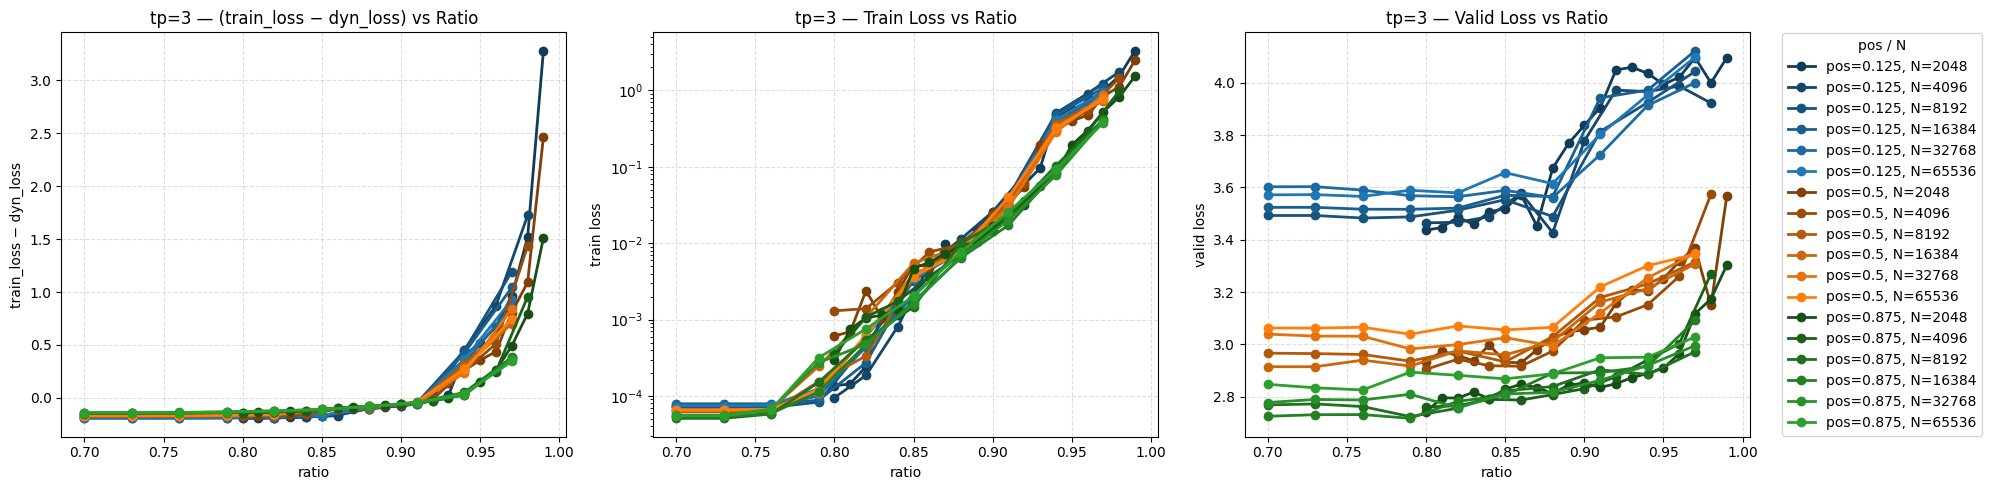

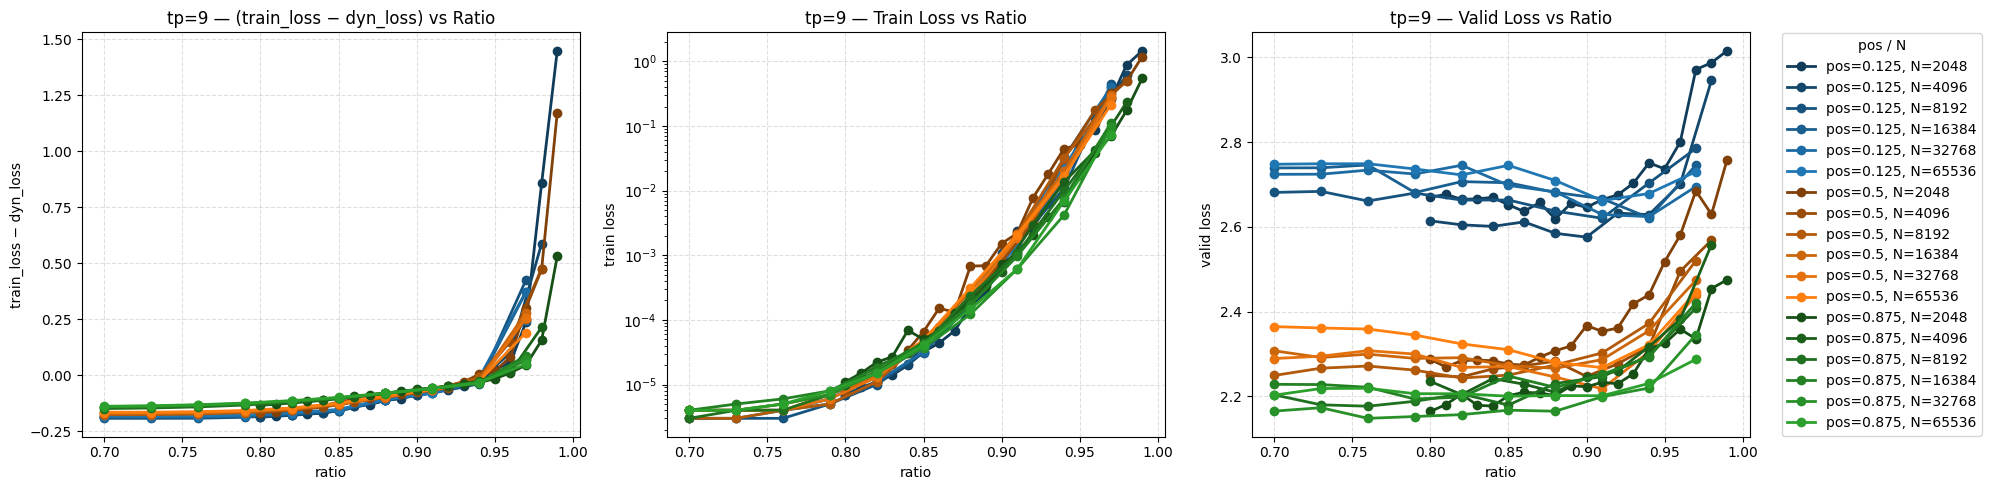

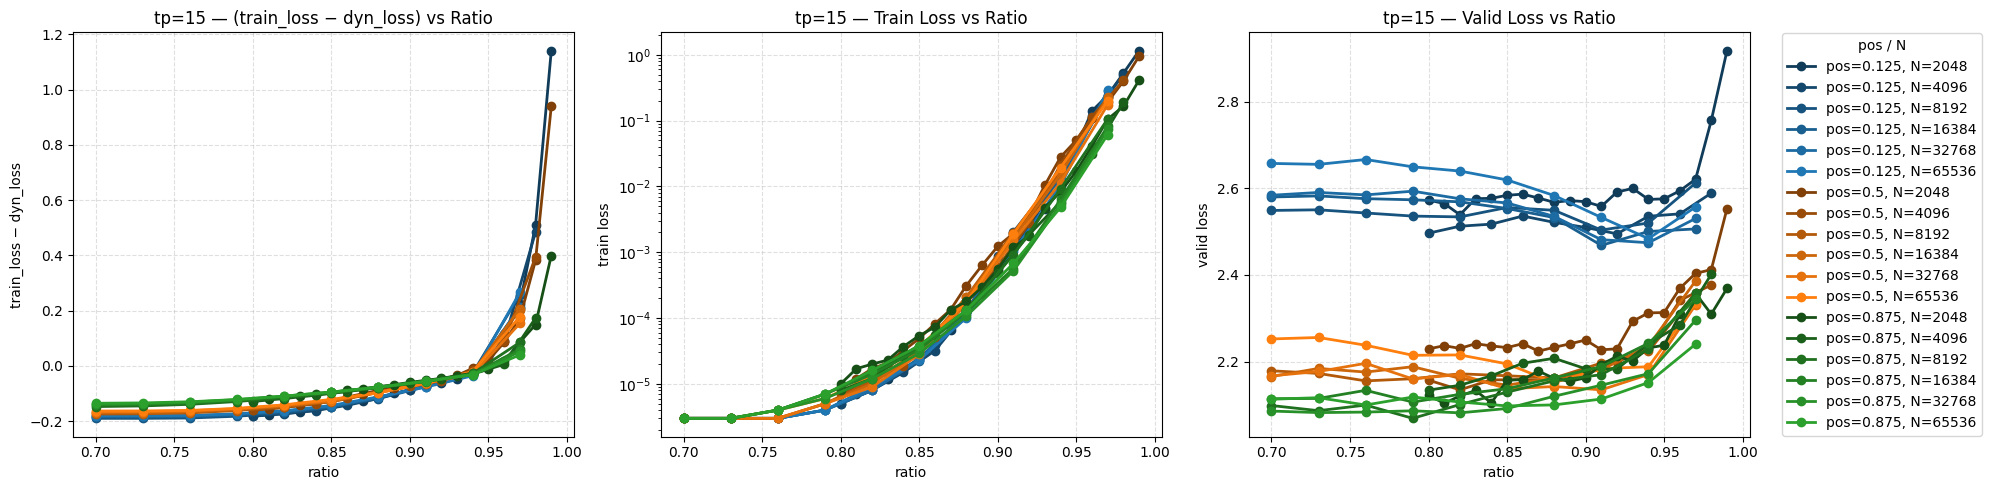

In [7]:
plot_loss_vs_ratio_swap_pos_N(results, N_list=[2048, 4096, 8192, 16384, 32768, 65536])


/tmp/ipykernel_451206/258030942.py:86: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[0].set_ylim(y_min, y_max)


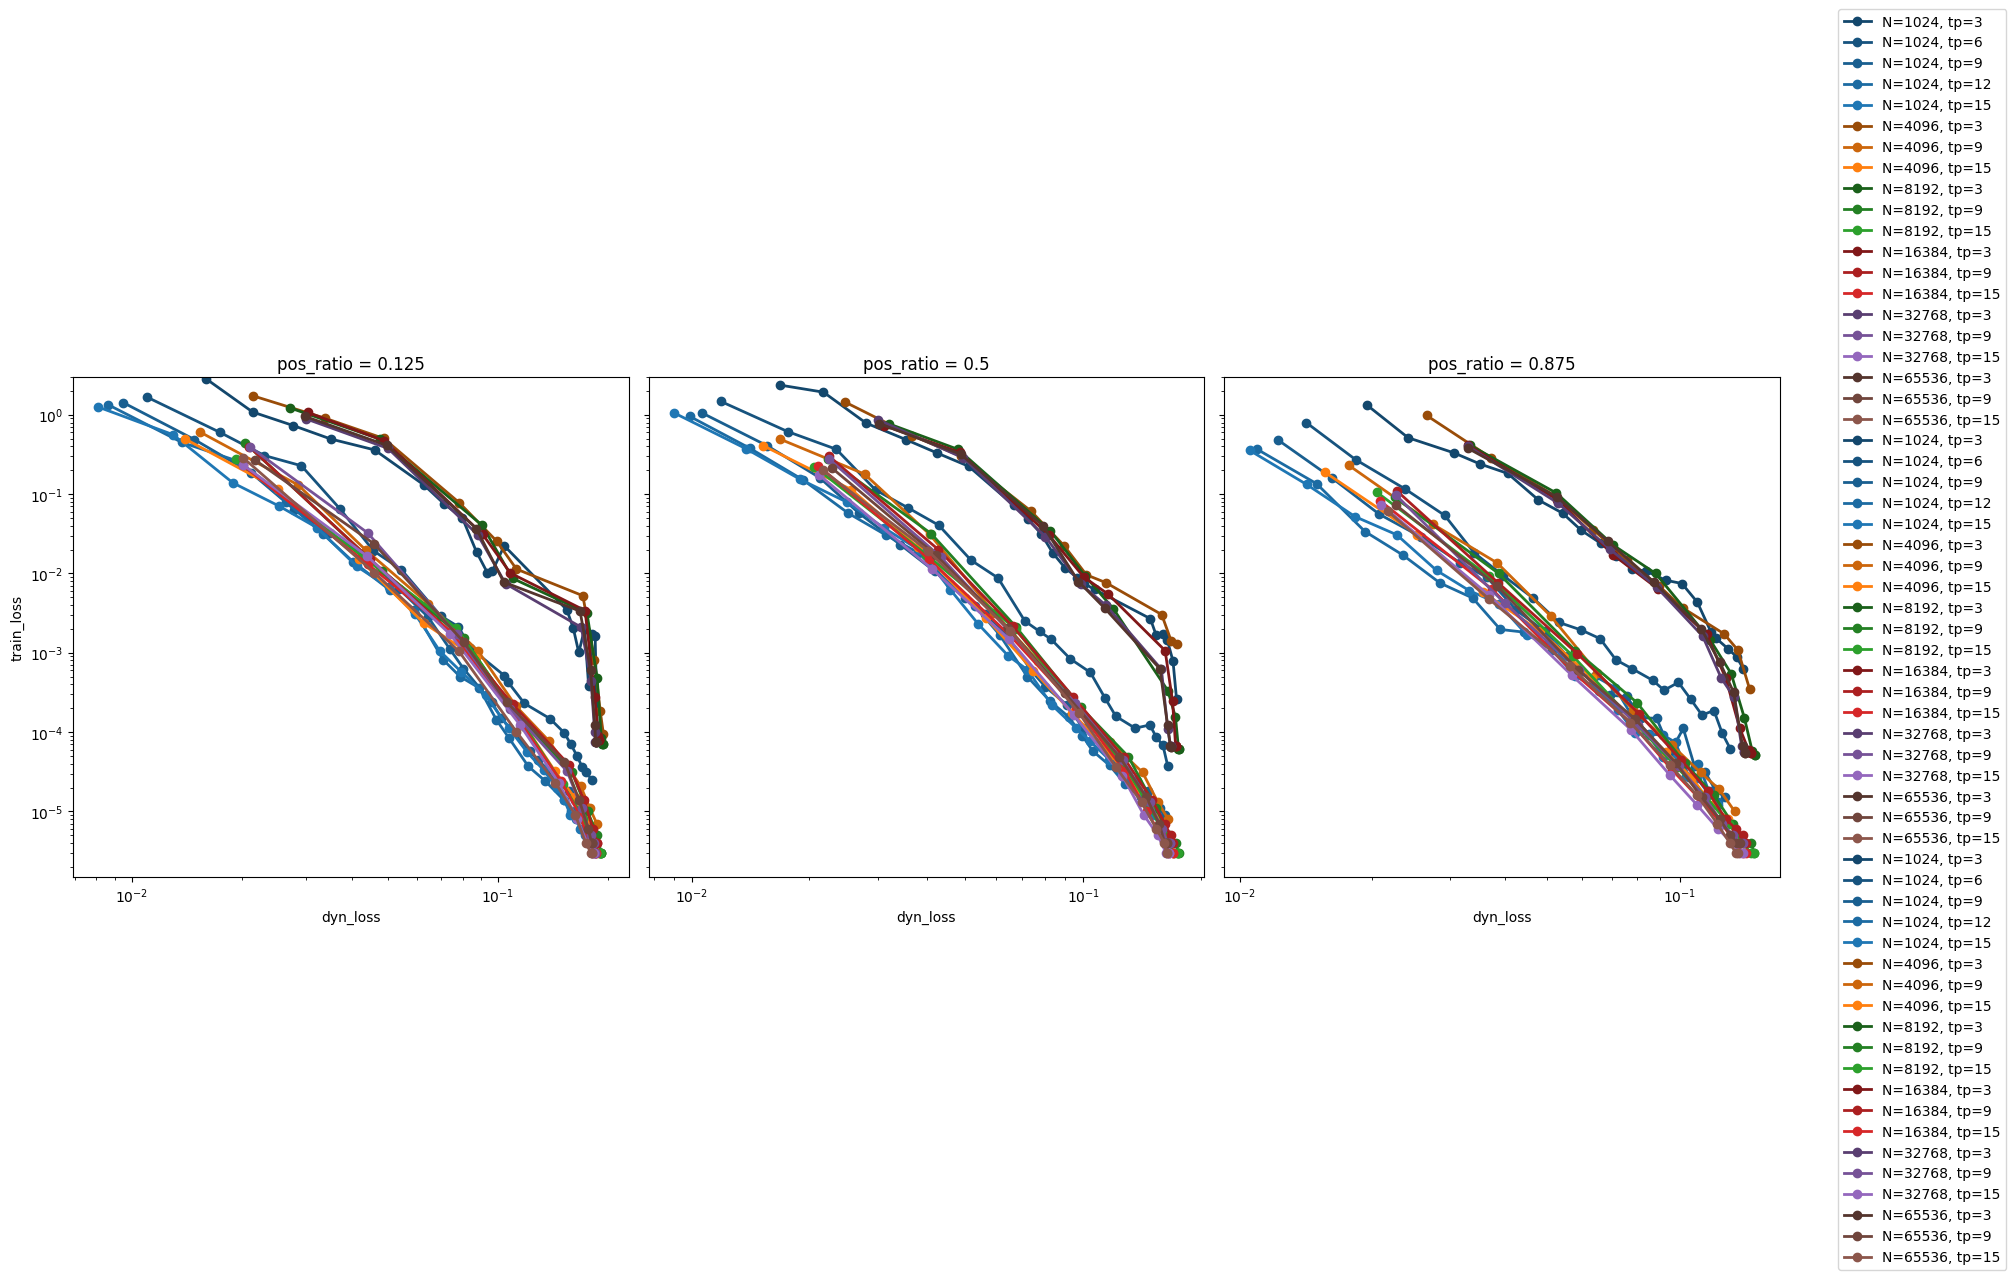

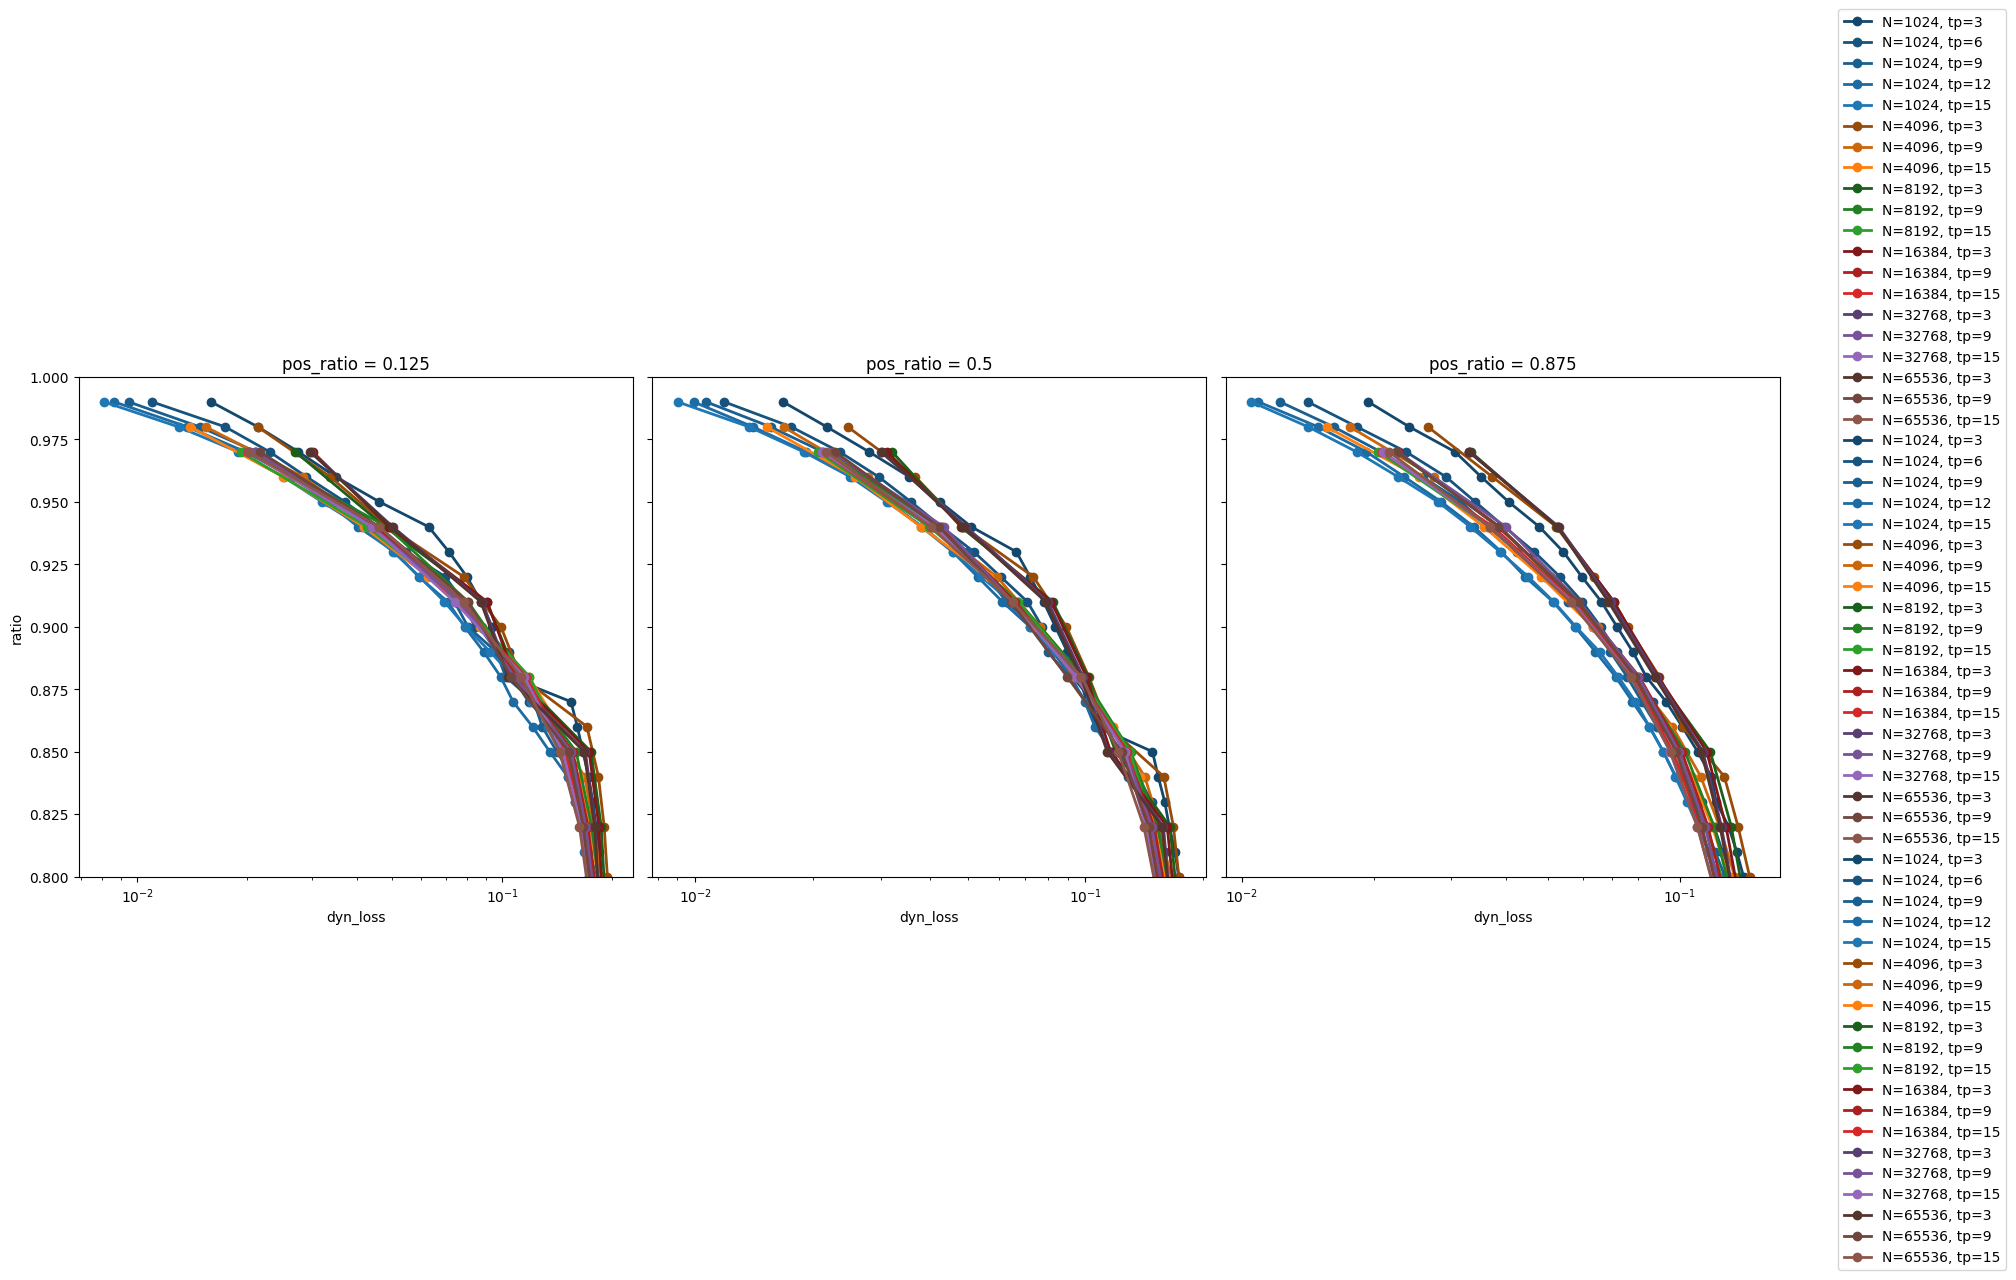

In [9]:

def plot_dyn_vs_train_multi(results, Ns, pos_list=[0.125,0.5,0.875]):
    """
    每个 figure 绘制 len(pos_list) 个 axis（横排）
    - 每个 axis：固定 pos_ratio
    - x: dyn_loss
    - y: train_loss
    - 不同 N 不同颜色
    - 同一 N 内 tp 小→浅、tp 大→深
    - 所有 y 轴共享
    """

    # ------------- 预扫描 y 轴范围（统一 y 轴用） -------------
    y_min, y_max = np.inf, -np.inf

    for N in Ns:
        if N not in results: continue
        for tp, tp_dict in results[N].items():
            for pos in pos_list:
                if pos not in tp_dict: continue
                for r, d in tp_dict[pos].items():
                    if d["train_loss"] is not None:
                        y_min = min(y_min, d["train_loss"])
                        y_max = max(y_max, d["train_loss"])

    if y_min == np.inf:
        print("No data found.")
        return

    # 美化一下范围
    y_pad = (y_max - y_min) * 0.05
    y_min -= y_pad
    y_max += y_pad

    # ------------- 创建子图 -------------
    num_pos = len(pos_list)
    fig, axes = plt.subplots(1, num_pos, figsize=(6*num_pos, 6), sharey=True)

    if num_pos == 1:
        axes = [axes]

    base_cmap = plt.get_cmap("tab10")

    # ------------- 绘图循环 -------------
    for ax, pos in zip(axes, pos_list):

        for idx_N, N in enumerate(Ns):
            if N not in results:
                continue

            base_color = np.array(base_cmap(idx_N % 10))
            tp_list = sorted(results[N].keys())
            num_tp = len(tp_list)

            for i, tp in enumerate(tp_list):

                if pos not in results[N][tp]:
                    continue

                # 颜色深浅
                depth = 0.6 + 0.4 * (i / max(1, num_tp - 1))
                color = base_color.copy()
                color[:3] *= depth
                color = np.clip(color, 0, 1)

                items = sorted(results[N][tp][pos].items(), key=lambda x: x[0])

                dyn_vals   = [d["dyn_loss"]   for _, d in items if d["dyn_loss"]   is not None]
                train_vals = [d["train_loss"] for _, d in items if d["train_loss"] is not None]

                if not dyn_vals:
                    continue

                ax.plot(
                    dyn_vals, train_vals,
                    marker="o",
                    color=color, linewidth=2,
                    label=f"N={N}, tp={tp}"
                )

        ax.set_title(f"pos_ratio = {pos}")
        ax.set_xlabel("dyn_loss")
        ax.set_xscale("log")
        ax.set_yscale("log")

    axes[0].set_ylabel("train_loss")  # 共享 y 轴
    axes[0].set_ylim(y_min, y_max)

    # 单独放 legend
    fig.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

    plt.tight_layout()
    plt.show()
def plot_dyn_vs_ratio_multi(results, Ns, pos_list=[0.125,0.5,0.875]):
    """
    每个 figure 绘制 len(pos_list) 个 axis（横排）
    - 每个 axis 对应一个 pos_ratio
    - x: dyn_loss
    - y: ratio
    - 不同 N = 不同颜色
    - 同一 N 内 tp 小→浅、tp 大→深
    - 所有 y 轴统一（自然为 [0,1]）
    """

    num_pos = len(pos_list)
    fig, axes = plt.subplots(1, num_pos, figsize=(6*num_pos, 6), sharey=True)

    if num_pos == 1:
        axes = [axes]

    base_cmap = plt.get_cmap("tab10")

    for ax, pos in zip(axes, pos_list):

        for idx_N, N in enumerate(Ns):
            if N not in results:
                continue

            base_color = np.array(base_cmap(idx_N % 10))
            tp_list = sorted(results[N].keys())
            num_tp = len(tp_list)

            for i, tp in enumerate(tp_list):
                if pos not in results[N][tp]:
                    continue

                depth = 0.6 + 0.4 * (i / max(1, num_tp - 1))
                color = base_color.copy()
                color[:3] *= depth
                color = np.clip(color, 0, 1)

                items = sorted(results[N][tp][pos].items(), key=lambda x: x[0])

                dyn_vals = []
                ratio_vals = []

                for r, d in items:
                    if d["dyn_loss"] is not None:
                        dyn_vals.append(d["dyn_loss"])
                        ratio_vals.append(r)

                if not dyn_vals:
                    continue

                ax.plot(
                    dyn_vals, ratio_vals,
                    marker="o", linewidth=2, color=color,
                    label=f"N={N}, tp={tp}"
                )

        ax.set_title(f"pos_ratio = {pos}")
        ax.set_xlabel("dyn_loss")
        ax.set_xscale("log")

    axes[0].set_ylabel("ratio")
    axes[0].set_ylim(0.8, 1)

    fig.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

    plt.tight_layout()
    plt.show()

Ns = [1024, 4096, 8192, 16384, 32768, 65536]

plot_dyn_vs_train_multi(results, Ns)
plot_dyn_vs_ratio_multi(results, Ns)


In [ ]:
import plotly.graph_objects as go

def plot_3d_ratio_train_valid_plotly(results, N, t_filter):
    fig = go.Figure()

    tp_list = sorted(results[N].keys())
    num_tp = len(tp_list)

    # 色系：PuBu 渐变
    import numpy as np
    cmap = plt.get_cmap("PuBu")
    colors = [cmap(v) for v in np.linspace(0.3, 1.0, num_tp)]

    for color, tp in zip(colors, tp_list):
        if t_filter not in results[N][tp]:
            continue

        items = sorted(results[N][tp][t_filter].items(), key=lambda x: x[0])
        dyn_vals = [d["dyn_loss"] for _, d in items]
        train_vals = [d["train_loss"] for _, d in items]
        valid_vals = [d["valid_loss"] for _, d in items]

        # matplotlib color 转 plotly RGB
        rgb = f"rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})"

        fig.add_trace(go.Scatter3d(
            x=dyn_vals,
            y=train_vals,
            z=valid_vals,
            mode="lines+markers",
            marker=dict(size=4, color=rgb),
            line=dict(color=rgb, width=3),
            name=f"tp={tp}",
        ))

    fig.update_layout(
        width=850, height=700,
        scene=dict(
            xaxis_title="train loss",
            yaxis_title="dyn loss",
            zaxis_title="valid loss",
        ),
        title=f"3D Dyn–Train-Valid (N={N}, t={t_filter})"
    )
    
    fig.update_layout(scene=dict(
        xaxis=dict(type="log"),
        yaxis=dict(type="log"),
    ))

    fig.show()
plot_3d_ratio_train_valid_plotly(results, N=2048, t_filter=10)

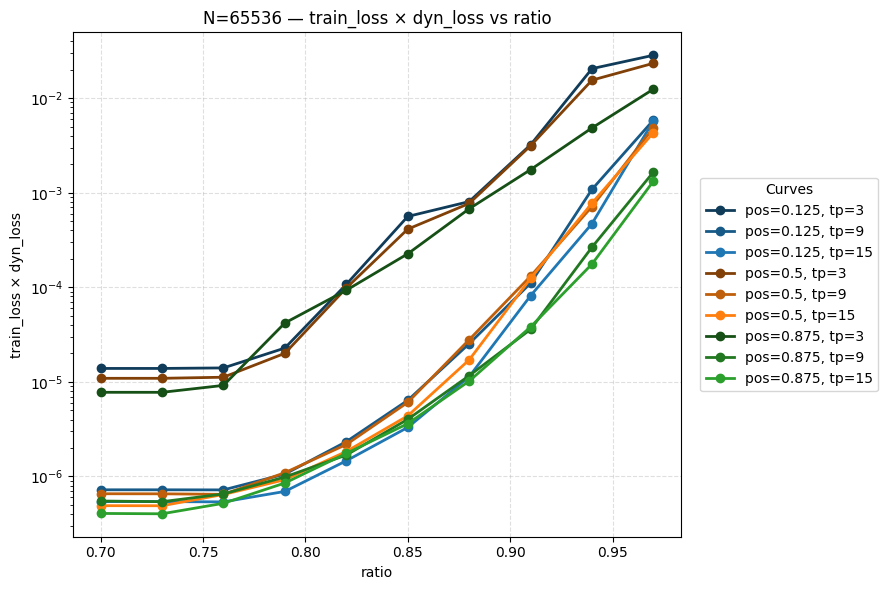

In [15]:
def plot_train_dyn_product(results, N, pos_list=None):
    """
    绘制 (train_loss * dyn_loss) vs ratio
    - 所有 pos_ratio 全部绘制到同一张图
    - 不同 pos_ratio 用不同主色（tab10）
    - 同一 pos_ratio 内：tp 小->浅，tp 大->深（渐变）
    - 无 t_filter（即不再按 t 索引）
    """

    import numpy as np
    import matplotlib.pyplot as plt

    if N not in results:
        raise ValueError(f"No data for N={N}")

    # 所有 tp
    tp_list = sorted(results[N].keys())

    # 自动收集 pos_list
    if pos_list is None:
        pos_set = set()
        for tp in results[N]:
            pos_set |= set(results[N][tp].keys())
        pos_list = sorted(pos_set)

    # 主色：不同 pos_ratio
    base_cmap = plt.get_cmap("tab10")

    fig, ax = plt.subplots(figsize=(9, 6))

    for idx_pos, pos in enumerate(pos_list):
        base_color = np.array(base_cmap(idx_pos % 10))

        # 渐变色用于不同 tp
        tp_list = sorted(results[N].keys())
        num_tp = len(tp_list)

        for i, tp in enumerate(tp_list):

            # 无此 pos_ratio 跳过
            if pos not in results[N][tp]:
                continue

            # 色深度（tp 小→浅）
            depth = 0.5 + 0.5 * (i / max(1, num_tp - 1))
            color = base_color.copy()
            color[:3] *= depth      # 只乘 RGB，不乘 alpha
            color = np.clip(color, 0, 1)

            # ratio → train_loss × dyn_loss
            items = sorted(results[N][tp][pos].items(), key=lambda x: x[0])
            ratios = []
            prod_vals = []

            for r, d in items:
                if d["train_loss"] is not None and d["dyn_loss"] is not None:
                    ratios.append(r)
                    prod_vals.append(d["train_loss"] * d["dyn_loss"])

            if not ratios:
                continue

            ax.plot(
                ratios, prod_vals,
                marker="o",
                linewidth=2,
                color=color,
                label=f"pos={pos}, tp={tp}"
            )

    ax.set_xlabel("ratio")
    ax.set_ylabel("train_loss × dyn_loss")
    ax.set_title(f"N={N} — train_loss × dyn_loss vs ratio")
    ax.set_yscale("log")

    ax.grid(True, linestyle="--", alpha=0.4)

    # Legend 放右侧
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), title="Curves")

    plt.tight_layout()
    plt.show()

plot_train_dyn_product(results, N=65536 )

